In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load and preprocess the data
data = pd.read_excel('IND.xlsx')
time_series = data[['year', 'debt']].set_index('year')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM Model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_test, y_test))
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# ARIMA Model
arima_model = ARIMA(time_series, order=(1,2,2))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(y_test))
arima_forecast = arima_forecast.values.reshape(-1, 1)

# Combine LSTM and ARIMA predictions using a weighted approach
alpha = 0.8  # Weight factor (can be tuned)
hybrid_predictions = alpha * test_predictions + (1 - alpha) * arima_forecast

# Evaluation
metrics = {
    'MAE': mean_absolute_error(y_test_actual, hybrid_predictions),
    'MSE': mean_squared_error(y_test_actual, hybrid_predictions),
    'RMSE': np.sqrt(mean_squared_error(y_test_actual, hybrid_predictions)),
    'MAPE': np.mean(np.abs((y_test_actual - hybrid_predictions) / y_test_actual)) * 100
}

print("\nHybrid Model Evaluation:")
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')


Epoch 1/500


c:\Users\dhevi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - loss: 0.0183 - val_loss: 0.3235
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0055 - val_loss: 0.2613
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0054 - val_loss: 0.2384
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0052 - val_loss: 0.2108
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0057 - val_loss: 0.1964
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0045 - val_loss: 0.1746
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0039 - val_loss: 0.1541
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0038 - val_loss: 0.1326
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0039 - val_loss: 0.1219
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0032 - val_loss: 0.1045
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0035 - val_loss: 0.0810
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0037 - val_loss: 0.07

c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

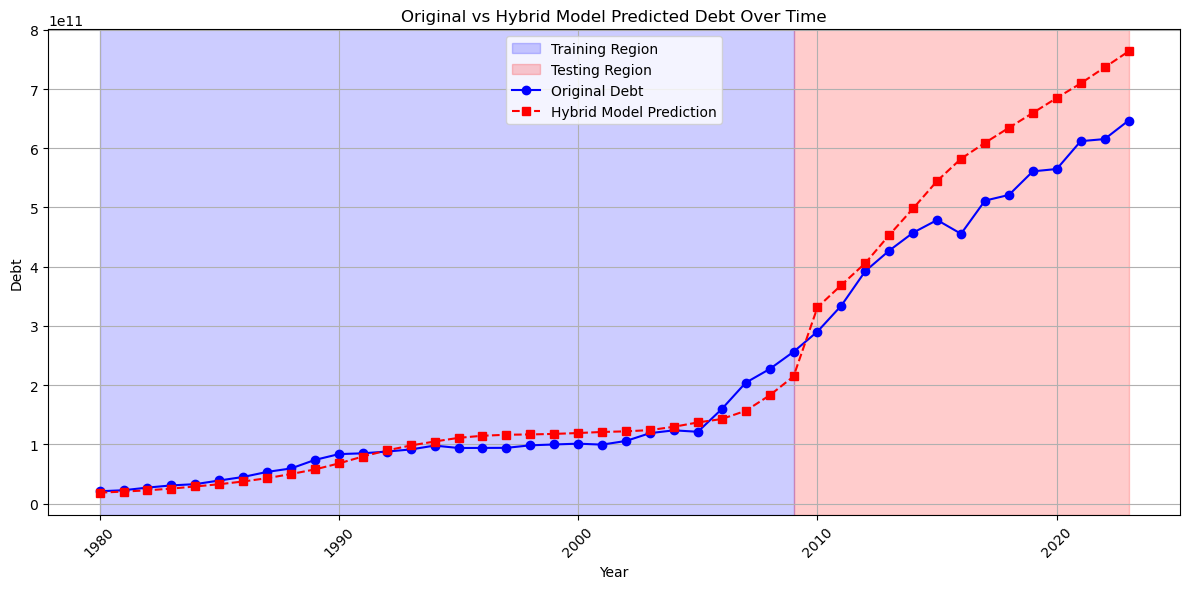

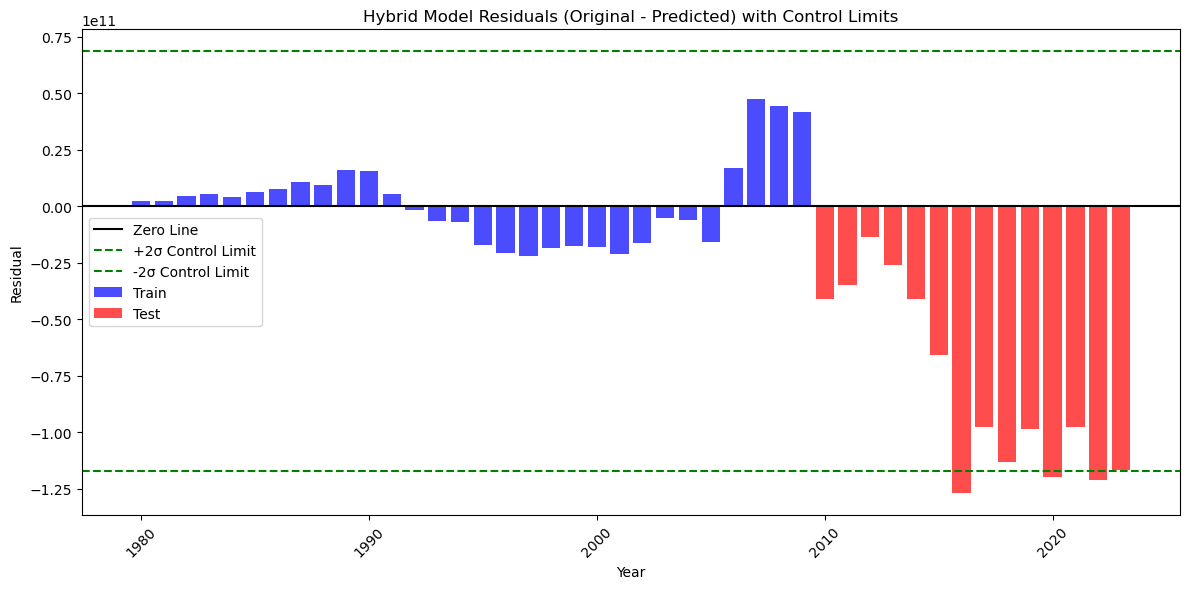

In [3]:
import matplotlib.pyplot as plt
# Get the years directly from your original data
years = data['year'].values  # Using the year values from your dataframe

# Calculate what years correspond to our predictions
seq_length = 10  # Same as in your model
# For train predictions, we need years that correspond to the target values
train_years = years[seq_length:train_size+seq_length]
test_years = years[train_size+seq_length:]

# Flatten arrays to ensure consistency
train_predictions_flat = train_predictions.flatten()
y_train_actual_flat = y_train_actual.flatten()
hybrid_predictions_flat = hybrid_predictions.flatten()
y_test_actual_flat = y_test_actual.flatten()

# Plot actual vs predicted using the extracted years - with only 2 colors
plt.figure(figsize=(12, 6))

# Combine train and test data for consistent coloring
all_years = np.concatenate([train_years, test_years])
all_actual = np.concatenate([y_train_actual_flat, y_test_actual_flat])
all_predicted = np.concatenate([train_predictions_flat, hybrid_predictions_flat])

# Shade the training and testing regions
split_year = train_years[-1]
min_y, max_y = min(np.min(all_actual), np.min(all_predicted)) * 0.9, max(np.max(all_actual), np.max(all_predicted)) * 1.1
plt.axvspan(min(train_years), split_year, alpha=0.2, color='blue', label='Training Region')
plt.axvspan(split_year, max(test_years), alpha=0.2, color='red', label='Testing Region')

# Plot with only two colors - blue for actual, red for predicted
plt.plot(all_years, all_actual, 'o-', color='blue', label='Original Debt')
plt.plot(all_years, all_predicted, 's--', color='red', label='Hybrid Model Prediction')

# Format plot
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Debt')
plt.title('Original vs Hybrid Model Predicted Debt Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('hybrid_debt_prediction.png', dpi=300)
plt.show()

# Calculate residuals
train_residuals = y_train_actual_flat - train_predictions_flat
test_residuals = y_test_actual_flat - hybrid_predictions_flat

# Calculate control limits (±2 standard deviations)
all_residuals = np.concatenate([train_residuals, test_residuals])
std_residuals = np.std(all_residuals)
mean_residuals = np.mean(all_residuals)
upper_control = mean_residuals + 2 * std_residuals
lower_control = mean_residuals - 2 * std_residuals

# Plot residuals
plt.figure(figsize=(12, 6))
plt.bar(train_years, train_residuals, color='blue', alpha=0.7, label='Train')
plt.bar(test_years, test_residuals, color='red', alpha=0.7, label='Test')

# Add control limit lines
plt.axhline(y=0, color='k', linestyle='-', label='Zero Line')
plt.axhline(y=upper_control, color='green', linestyle='--', label='+2σ Control Limit')
plt.axhline(y=lower_control, color='green', linestyle='--', label='-2σ Control Limit')

plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Hybrid Model Residuals (Original - Predicted) with Control Limits')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('hybrid_debt_residuals.png', dpi=300)
plt.show()

In [6]:
# Forecast future 10 years
future_steps = 10

# LSTM Forecast
lstm_input = X_test[-1].reshape(1, X_test.shape[1], 1)
lstm_forecast = []

for _ in range(future_steps):
    pred = model.predict(lstm_input, verbose=0)
    lstm_forecast.append(pred[0, 0])

    # Update input sequence with the new prediction
    lstm_input = np.append(lstm_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

lstm_forecast = np.array(lstm_forecast).reshape(-1, 1)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# ARIMA Forecast
arima_future_forecast = arima_fit.forecast(steps=future_steps)
arima_future_forecast = arima_future_forecast.values.reshape(-1, 1)

# Hybrid Forecast (Weighted Combination)
hybrid_forecast = alpha * lstm_forecast + (1 - alpha) * arima_future_forecast

# Display Forecast
future_years = np.arange(time_series.index[-1] + 1, time_series.index[-1] + future_steps + 1)
forecast_df = pd.DataFrame({'Year': future_years, 'Hybrid_Forecast': hybrid_forecast.flatten()})

print("\nFuture 10-Year Debt Forecast (Hybrid Model):")
print(forecast_df)


Future 10-Year Debt Forecast (Hybrid Model):
   Year  Hybrid_Forecast
0  2024     7.072520e+11
1  2025     7.509585e+11
2  2026     7.977874e+11
3  2027     8.534355e+11
4  2028     9.076820e+11
5  2029     9.687776e+11
6  2030     1.028285e+12
7  2031     1.092462e+12
8  2032     1.154000e+12
9  2033     1.218394e+12


c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dhevi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


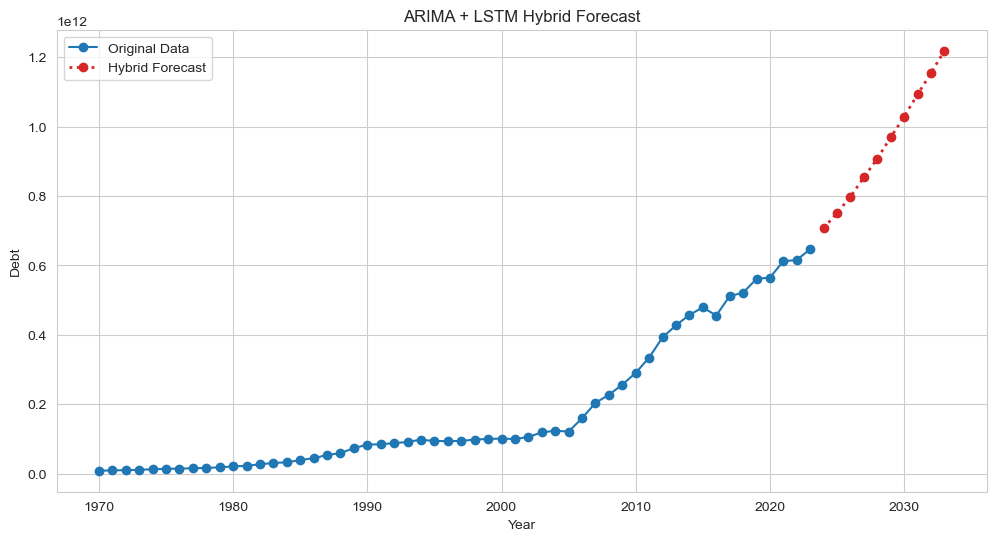

In [15]:
# Plot Original Data and Forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series.values, label='Original Data', marker='o')
plt.plot(forecast_df['Year'], forecast_df['Hybrid_Forecast'], label='Hybrid Forecast', linestyle=':', marker='o', color='#D62728', linewidth=2, markersize=6)

plt.xlabel('Year')
plt.ylabel('Debt')
plt.title('ARIMA + LSTM Hybrid Forecast')
plt.legend()
plt.grid(True)
plt.show()